# Установка библиотек

In [13]:
#!pip install joblib
#!pip install ta
#!pip install yfinance

# Импорт данных

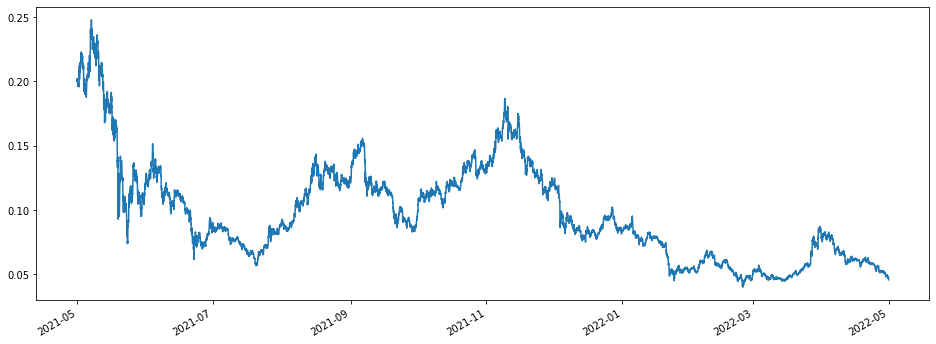

In [14]:
import joblib
from ta import add_all_ta_features
#import talib
import yfinance as yf
tickerS = "VET-USD"
tickerData = yf.Ticker(tickerS)
'''
max
1y
1mo
1wk
1d
1h
1m
'''
period_='1y'
interval_='1h'

start_="2021-05-01"
end_="2022-05-01"

tickerDf = tickerData.history(start=start_, end=end_, interval = interval_)
tickerDf.Close.plot(figsize=(16,6))

# Основные функции

In [15]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def box_cox(data, columnOld, columnNew):
    trans, lambda_ = boxcox(data[columnOld].values)
    data[columnNew] = trans
    return lambda_
    
def inv_box_cox(data, lambda_):
    return inv_boxcox(data, lambda_)
    
def diff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].diff()
    
def inv_diff(base, predict):
    summ=[i+j for i,j in zip(base[len(base)-len(predict)-1:-1], predict)]
    return np.array(summ).reshape(-1,1)

def minmax(data, columnOld, columnNew):
    scaler = MinMaxScaler()
    data[columnNew] = scaler.fit_transform(data[columnOld].values.reshape(-1,1))
    return scaler.fit(data[columnOld].values.reshape(-1,1))

def inv_minmax(data, obj):
    return obj.inverse_transform(data).reshape(-1,1)
    
def lag_fich(data, columnOld):
    prediction_window = 10
    prediction_columns = [columnOld]
    for i in range(1, prediction_window+1):
        col_name = f'shift_{i}'
        prediction_columns.append(col_name)
        data[col_name] = data[prediction_columns[0]].shift(i)
    
    return data[prediction_columns].dropna(), prediction_columns

def all_transform(dataf, pupu, box_cox_ch=1):
    if box_cox_ch == 1:
        lambda_dataf = box_cox(dataf, pupu, 'boxcox')
        data1 = dataf['boxcox'].copy()
        diff(dataf, 'boxcox', 'diff')
        return lambda_dataf, data1
    else:
        lambda_dataf = 0
        data1 = dataf[pupu].copy()
        diff(dataf, pupu, 'diff')
        return lambda_dataf, data1
    
def inv_all_transform(data1, data_test, lambda_data, box_cox_ch=1):
    if box_cox_ch == 1:
        inv_data_test_from_diff_to_boxcox = inv_diff(data1, data_test.values.reshape(-1,1))
        inv_data_test = inv_boxcox(inv_data_test_from_diff_to_boxcox, lambda_data)
        return inv_data_test
    else:
        inv_data_test = inv_diff(data1, data_test.values.reshape(-1,1))
        return inv_data_test

def add_feature(name, feature, prediction_columns, high, low):
    prediction_columns.append(name)

    high[name] = feature[len(feature)-len(high):]
    low[name] = feature[len(feature)-len(low):]
    
def metrics(predicted, real):
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error (MSE)', mean_squared_error(predicted,real))

    from sklearn.metrics import mean_absolute_error
    print('mean_absolute_error (MAE)', mean_absolute_error(predicted, real))

    from sklearn.metrics import mean_absolute_percentage_error
    print('mean_absolute_percentage_error (MAPE)', mean_absolute_percentage_error(predicted, real))
    
    from sklearn.metrics import r2_score
    print('r2_score (R^2)', r2_score(predicted,real))
    

################

# Предобработка данных

In [16]:

low = tickerDf[:].copy()
high = tickerDf[:].copy()
close = tickerDf[:].copy()

high_real = high['High'].copy()
low_real = low['Low'].copy()

'''
lambda_high = box_cox(high, 'High', 'boxcox')
lambda_low = box_cox(low, 'Low', 'boxcox')
#lambda_close =boxcoxMy(close, 'Close', 'boxcox')
high1 = high['boxcox'].copy()
low1 = low['boxcox'].copy()

diff(high, 'boxcox', 'diff')
diff(low, 'boxcox', 'diff')
'''
#diff(close, 'boxcox', 'diff')
#high_min = minmax(high, 'diff', 'minmax_scaler')
#low_min = minmax(low, 'diff', 'minmax_scaler')
#minmax(close, 'boxcox', 'minmax_scaler')

"\nlambda_high = box_cox(high, 'High', 'boxcox')\nlambda_low = box_cox(low, 'Low', 'boxcox')\n#lambda_close =boxcoxMy(close, 'Close', 'boxcox')\nhigh1 = high['boxcox'].copy()\nlow1 = low['boxcox'].copy()\n\ndiff(high, 'boxcox', 'diff')\ndiff(low, 'boxcox', 'diff')\n"

In [17]:
diff_ch=0
box_cox_ch=0 #box_cox только с diff

if diff_ch ==1:
    
    lambda_high, high1 = all_transform(high, 'High', box_cox_ch)
    lambda_low, low1= all_transform(low, 'Low', box_cox_ch)


In [18]:
if box_cox_ch == 1:
    high['boxcox'].plot(figsize=(16,6), linewidth = 1)

In [19]:
if diff_ch == 1:
    high, prediction_columns = lag_fich(high, 'diff')

    low, prediction_columns = lag_fich(low, 'diff')
else:
    high, prediction_columns_high = lag_fich(high, 'High')

    low, prediction_columns_low = lag_fich(low, 'Low')

In [20]:
if diff_ch == 1:
    high['diff'].plot(figsize=(16,6), linewidth = 1)

# Фичи

In [21]:
dop_fich_BTC = 0
dop_fich = 0
period_indic = '2y'

if dop_fich_BTC == 1:
    ''''''
    tickerBTC = "BTC-USD"
    tickerDataBTC = yf.Ticker(tickerBTC)
    tickerDf_features_BTC = tickerDataBTC.history(start=start_, end=end_, interval = interval_)

    featuresBTC_high = tickerDf_features_BTC[:-1].shift().copy()
    featuresBTC_low = tickerDf_features_BTC[:-1].shift().copy()

    _ , _ = all_transform(featuresBTC_high, 'High', box_cox_ch)

    _ , _ = all_transform(featuresBTC_low, 'Low', box_cox_ch)

    prediction_columns.append('BTC')

    high['BTC'] = featuresBTC_high['diff'][len(featuresBTC_high['diff'])-len(high):]
    low['BTC'] = featuresBTC_low['diff'][len(featuresBTC_low['diff'])-len(low):]

    ###############


    

    tickerDf_features_BTC_indic = tickerDataBTC.history(start=start_, end=end_, interval = interval_)
    features = tickerDf_features_BTC_indic[:-1].copy()

    #60

    #Momentum Indicator Functions - 22

    output = talib.WILLR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('WILLR_BTC', output, prediction_columns, high, low)

    output = talib.PLUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('PLUS_DI_BTC', output, prediction_columns, high, low)

    output = talib.DX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('DX_BTC', output, prediction_columns, high, low)

    output = talib.CCI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('CCI_BTC', output, prediction_columns, high, low)

    output = talib.ADXR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADXR_BTC', output, prediction_columns, high, low)

    output = talib.ULTOSC(features['High'], features['Low'], features['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    add_feature('ULTOSC_BTC', output, prediction_columns, high, low)

    output = talib.ADX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADX_BTC', output, prediction_columns, high, low)

    output = talib.APO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('APO_BTC', output, prediction_columns, high, low)

    output = talib.AROONOSC(features['High'], features['Low'], timeperiod=14)
    add_feature('AROONOSC_BTC', output, prediction_columns, high, low)

    output = talib.BOP(features['Open'], features['High'], features['Low'], features['Close'])
    add_feature('BOP_BTC', output, prediction_columns, high, low)

    output = talib.CMO(features['Close'], timeperiod=14)
    add_feature('CMO_BTC', output, prediction_columns, high, low)

    output = talib.MINUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('MINUS_DI_BTC', output, prediction_columns, high, low)

    output = talib.MINUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('MINUS_DM_BTC', output, prediction_columns, high, low)

    output = talib.MOM(features['Close'], timeperiod=10)
    add_feature('MOM_BTC', output, prediction_columns, high, low)

    output = talib.PLUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('PLUS_DM_BTC', output, prediction_columns, high, low)

    output = talib.PPO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('PPO_BTC', output, prediction_columns, high, low)

    output = talib.ROC(features['Close'], timeperiod=10)
    add_feature('ROC_BTC', output, prediction_columns, high, low)

    output = talib.ROCP(features['Close'], timeperiod=10)
    add_feature('ROCP_BTC', output, prediction_columns, high, low)

    output = talib.ROCR(features['Close'], timeperiod=10)
    add_feature('ROCR_BTC', output, prediction_columns, high, low)

    output = talib.ROCR100(features['Close'], timeperiod=10)
    add_feature('ROCR100_BTC', output, prediction_columns, high, low)

    output = talib.RSI(features['Close'], timeperiod=14)
    add_feature('RSI_BTC', output, prediction_columns, high, low)

    output = talib.TRIX(features['Close'], timeperiod=30)
    add_feature('TRIX_BTC', output, prediction_columns, high, low)


    #Overlap Studies Functions - 11

    output = talib.MIDPRICE(features['High'], features['Low'], timeperiod=14)
    add_feature('MIDPRICE_BTC', output, prediction_columns, high, low)

    output = talib.DEMA(features['Close'], timeperiod=30)
    add_feature('DEMA_BTC', output, prediction_columns, high, low)

    output = talib.EMA(features['Close'], timeperiod=30)
    add_feature('EMA_BTC', output, prediction_columns, high, low)

    output = talib.HT_TRENDLINE(features['Close'])
    add_feature('HT_TRENDLINE_BTC', output, prediction_columns, high, low)

    output = talib.KAMA(features['Close'], timeperiod=30)
    add_feature('KAMA_BTC', output, prediction_columns, high, low)

    output = talib.MA(features['Close'], timeperiod=30, matype=0)
    add_feature('MA_BTC', output, prediction_columns, high, low)

    output = talib.MIDPOINT(features['Close'], timeperiod=14)
    add_feature('MIDPOINT_BTC', output, prediction_columns, high, low)

    output = talib.SMA(features['Close'], timeperiod=30)
    add_feature('SMA_BTC', output, prediction_columns, high, low)

    output = talib.TEMA(features['Close'], timeperiod=30)
    add_feature('TEMA_BTC', output, prediction_columns, high, low)

    output = talib.TRIMA(features['Close'], timeperiod=30)
    add_feature('TRIMA_BTC', output, prediction_columns, high, low)

    output = talib.WMA(features['Close'], timeperiod=30)
    add_feature('WMA_BTC', output, prediction_columns, high, low)


    #Volatility Indicator Functions - 3

    output = talib.ATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ATR_BTC', output, prediction_columns, high, low)

    output = talib.NATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('NATR_BTC', output, prediction_columns, high, low)

    output = talib.TRANGE(features['High'], features['Low'], features['Close'])
    add_feature('TRANGE_BTC', output, prediction_columns, high, low)



    #Cycle Indicator Functions - 3

    output = talib.HT_DCPERIOD(features['Close'])
    add_feature('HT_DCPERIOD_BTC', output, prediction_columns, high, low)

    output = talib.HT_DCPHASE(features['Close'])
    add_feature('WHT_DCPHASEMA_BTC', output, prediction_columns, high, low)

    output = talib.HT_TRENDMODE(features['Close'])
    add_feature('HT_TRENDMODE_BTC', output, prediction_columns, high, low)



    #Statistic Functions - 8

    output = talib.BETA(features['High'], features['Low'], timeperiod=5)
    add_feature('BETA_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG(features['Close'], timeperiod=14)
    add_feature('LINEARREG_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_ANGLE(features['Close'], timeperiod=14)
    add_feature('WLINEARREG_ANGLEMA_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_INTERCEPT(features['Close'], timeperiod=14)
    add_feature('LINEARREG_INTERCEPT_BTC', output, prediction_columns, high, low)

    output = talib.LINEARREG_SLOPE(features['Close'], timeperiod=14)
    add_feature('LINEARREG_SLOPE_BTC', output, prediction_columns, high, low)

    output = talib.STDDEV(features['Close'], timeperiod=5, nbdev=1)
    add_feature('STDDEV_BTC', output, prediction_columns, high, low)

    output = talib.TSF(features['Close'], timeperiod=14)
    add_feature('TSF_BTC', output, prediction_columns, high, low)

    output = talib.VAR(features['Close'], timeperiod=5, nbdev=1)
    add_feature('VAR_BTC', output, prediction_columns, high, low)
    
    ''''''
    
    len(prediction_columns)-11
    

In [22]:

if dop_fich ==1:
    tickerDf_features = tickerData.history(start="2021-03-01", end=end_, interval = interval_)
    features = tickerDf_features[:-1].copy()


    ############

    high_fich = add_all_ta_features(features, 
                                   open = 'Open', 
                                   high = 'High', 
                                   low = 'Low', 
                                   close = 'Close', 
                                   volume = 'Volume', 
                                   fillna = True)

    low_fich = add_all_ta_features(features, 
                                   open = 'Open', 
                                   high = 'High', 
                                   low = 'Low', 
                                   close = 'Close', 
                                   volume = 'Volume', 
                                   fillna = True)

    for i in high_fich.columns.tolist()[7:]:
        high[i] = high_fich[i]
        low[i] = low_fich[i]
        prediction_columns.append(i)

    ############

    #60

    #Momentum Indicator Functions - 22

    output = talib.WILLR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('WILLR', output, prediction_columns, high, low)

    output = talib.PLUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('PLUS_DI', output, prediction_columns, high, low)

    output = talib.DX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('DX', output, prediction_columns, high, low)

    output = talib.CCI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('CCI', output, prediction_columns, high, low)

    output = talib.ADXR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADXR', output, prediction_columns, high, low)

    output = talib.ULTOSC(features['High'], features['Low'], features['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    add_feature('ULTOSC', output, prediction_columns, high, low)

    output = talib.ADX(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ADX', output, prediction_columns, high, low)

    output = talib.APO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('APO', output, prediction_columns, high, low)

    output = talib.AROONOSC(features['High'], features['Low'], timeperiod=14)
    add_feature('AROONOSC', output, prediction_columns, high, low)

    output = talib.BOP(features['Open'], features['High'], features['Low'], features['Close'])
    add_feature('BOP', output, prediction_columns, high, low)

    output = talib.CMO(features['Close'], timeperiod=14)
    add_feature('CMO', output, prediction_columns, high, low)

    output = talib.MINUS_DI(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('MINUS_DI', output, prediction_columns, high, low)

    output = talib.MINUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('MINUS_DM', output, prediction_columns, high, low)

    output = talib.MOM(features['Close'], timeperiod=10)
    add_feature('MOM', output, prediction_columns, high, low)

    output = talib.PLUS_DM(features['High'], features['Low'], timeperiod=14)
    add_feature('PLUS_DM', output, prediction_columns, high, low)

    output = talib.PPO(features['Close'], fastperiod=12, slowperiod=26, matype=0)
    add_feature('PPO', output, prediction_columns, high, low)

    output = talib.ROC(features['Close'], timeperiod=10)
    add_feature('ROC', output, prediction_columns, high, low)

    output = talib.ROCP(features['Close'], timeperiod=10)
    add_feature('ROCP', output, prediction_columns, high, low)

    output = talib.ROCR(features['Close'], timeperiod=10)
    add_feature('ROCR', output, prediction_columns, high, low)

    output = talib.ROCR100(features['Close'], timeperiod=10)
    add_feature('ROCR100', output, prediction_columns, high, low)

    output = talib.RSI(features['Close'], timeperiod=14)
    add_feature('RSI', output, prediction_columns, high, low)

    output = talib.TRIX(features['Close'], timeperiod=30)
    add_feature('TRIX', output, prediction_columns, high, low)


    #Overlap Studies Functions - 11

    output = talib.MIDPRICE(features['High'], features['Low'], timeperiod=14)
    add_feature('MIDPRICE', output, prediction_columns, high, low)

    output = talib.DEMA(features['Close'], timeperiod=30)
    add_feature('DEMA', output, prediction_columns, high, low)

    output = talib.EMA(features['Close'], timeperiod=30)
    add_feature('EMA', output, prediction_columns, high, low)

    output = talib.HT_TRENDLINE(features['Close'])
    add_feature('HT_TRENDLINE', output, prediction_columns, high, low)

    output = talib.KAMA(features['Close'], timeperiod=30)
    add_feature('KAMA', output, prediction_columns, high, low)

    output = talib.MA(features['Close'], timeperiod=30, matype=0)
    add_feature('MA', output, prediction_columns, high, low)

    output = talib.MIDPOINT(features['Close'], timeperiod=14)
    add_feature('MIDPOINT', output, prediction_columns, high, low)

    output = talib.SMA(features['Close'], timeperiod=30)
    add_feature('SMA', output, prediction_columns, high, low)

    output = talib.TEMA(features['Close'], timeperiod=30)
    add_feature('TEMA', output, prediction_columns, high, low)

    output = talib.TRIMA(features['Close'], timeperiod=30)
    add_feature('TRIMA', output, prediction_columns, high, low)

    output = talib.WMA(features['Close'], timeperiod=30)
    add_feature('WMA', output, prediction_columns, high, low)


    #Volatility Indicator Functions - 3

    output = talib.ATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('ATR', output, prediction_columns, high, low)

    output = talib.NATR(features['High'], features['Low'], features['Close'], timeperiod=14)
    add_feature('NATR', output, prediction_columns, high, low)

    output = talib.TRANGE(features['High'], features['Low'], features['Close'])
    add_feature('TRANGE', output, prediction_columns, high, low)



    #Cycle Indicator Functions - 3

    output = talib.HT_DCPERIOD(features['Close'])
    add_feature('HT_DCPERIOD', output, prediction_columns, high, low)

    output = talib.HT_DCPHASE(features['Close'])
    add_feature('WHT_DCPHASEMA', output, prediction_columns, high, low)

    output = talib.HT_TRENDMODE(features['Close'])
    add_feature('HT_TRENDMODE', output, prediction_columns, high, low)



    #Statistic Functions - 8

    output = talib.BETA(features['High'], features['Low'], timeperiod=5)
    add_feature('BETA', output, prediction_columns, high, low)

    output = talib.LINEARREG(features['Close'], timeperiod=14)
    add_feature('LINEARREG', output, prediction_columns, high, low)

    output = talib.LINEARREG_ANGLE(features['Close'], timeperiod=14)
    add_feature('WLINEARREG_ANGLEMA', output, prediction_columns, high, low)

    output = talib.LINEARREG_INTERCEPT(features['Close'], timeperiod=14)
    add_feature('LINEARREG_INTERCEPT', output, prediction_columns, high, low)

    output = talib.LINEARREG_SLOPE(features['Close'], timeperiod=14)
    add_feature('LINEARREG_SLOPE', output, prediction_columns, high, low)

    output = talib.STDDEV(features['Close'], timeperiod=5, nbdev=1)
    add_feature('STDDEV', output, prediction_columns, high, low)

    output = talib.TSF(features['Close'], timeperiod=14)
    add_feature('TSF', output, prediction_columns, high, low)

    output = talib.VAR(features['Close'], timeperiod=5, nbdev=1)
    add_feature('VAR', output, prediction_columns, high, low)



    #Math Transform Functions - 13

    output = talib.ACOS(features['Close'])
    add_feature('ACOS', output, prediction_columns, high, low)

    output = talib.ASIN(features['Close'])
    add_feature('ASIN', output, prediction_columns, high, low)

    output = talib.ATAN(features['Close'])
    add_feature('ATAN', output, prediction_columns, high, low)

    output = talib.COS(features['Close'])
    add_feature('COS', output, prediction_columns, high, low)

    output = talib.COSH(features['Close'])
    add_feature('COSH', output, prediction_columns, high, low)

    output = talib.EXP(features['Close'])
    add_feature('EXP', output, prediction_columns, high, low)

    output = talib.LN(features['Close'])
    add_feature('LN', output, prediction_columns, high, low)

    output = talib.LOG10(features['Close'])
    add_feature('LOG10', output, prediction_columns, high, low)

    output = talib.SIN(features['Close'])
    add_feature('SIN', output, prediction_columns, high, low)

    output = talib.SINH(features['Close'])
    add_feature('SINH', output, prediction_columns, high, low)

    output = talib.SQRT(features['Close'])
    add_feature('SQRT', output, prediction_columns, high, low)

    output = talib.TAN(features['Close'])
    add_feature('TAN', output, prediction_columns, high, low)

    output = talib.TANH(features['Close'])
    add_feature('TANH', output, prediction_columns, high, low)
    ''''''

    len(prediction_columns)-11

# Обучение - High

In [23]:
if diff_ch == 1:
    X = high[prediction_columns[1:]]
    y = high[prediction_columns[0]]
else:
    X = high[prediction_columns_high[1:]]
    y = high[prediction_columns_high[0]]

from sklearn.model_selection import train_test_split
high_x_train, high_x_test, high_train, high_test = train_test_split(X, y, test_size=0.33, random_state = 42, shuffle = False)

high_x_train.fillna(value = 0, inplace=True)
high_x_test.fillna(value = 0, inplace=True)
high_train.fillna(value = 0, inplace=True)
high_test.fillna(value = 0, inplace=True)

choose = 1


if choose == 1:
    from sklearn.linear_model import LinearRegression
    regressor_high = LinearRegression()
    regressor_high.fit(high_x_train, high_train)
    
elif choose == 2:
    ######### RandomForest
    max_depth_les = 100
    min_samples_leaf_les = 10
    #########
    from sklearn.ensemble import RandomForestRegressor
    regressor_high = RandomForestRegressor(max_depth=max_depth_les, random_state=0, min_samples_leaf=min_samples_leaf_les)
    regressor_high.fit(high_x_train, high_train)
    
elif choose == 3:
    ######### CatBoost
    iterations_cat=500    #500
    learning_rate_cat=0.03 #0.03
    depth_cat=8         #8
    l2_leaf_reg_cat=7
    #########
    from catboost import CatBoostRegressor
    regressor_high = CatBoostRegressor(iterations=iterations_cat,
                                       learning_rate=learning_rate_cat,
                                       depth=depth_cat,
                                       l2_leaf_reg=l2_leaf_reg_cat)
    regressor_high.fit(high_x_train, high_train)
    
elif choose == 4:
    from sklearn.neural_network import MLPRegressor
    ######### MLPRegressor
    test_size = 0.1
    validation_size = 0.1
    layers = (32, 8)
    Lambda = 1e-05
    batch_size = 64
    initial_learning_rate = 0.01
    epochs = 10**100 
    #########
    
    regressor_high = MLPRegressor(hidden_layer_sizes=layers,
                                  activation='logistic',
                                  solver='adam',
                                  alpha=Lambda,
                                  batch_size=batch_size,
                                  learning_rate='adaptive',
                                  learning_rate_init=initial_learning_rate,
                                  max_iter=epochs,
                                  shuffle=True,
                                  tol=0.0001,
                                  verbose=False,
                                  early_stopping=True,
                                  validation_fraction=validation_size)
    
    avg_score = 0
    avg_error = 0
    min_error = 1
    max_error = 0
    avg_conv_iter = 0
    skol_raz = 1000
    for i in range(skol_raz) :
        regressor_high.fit(high_x_train, high_train) 
        avg_score += regressor_high.best_validation_score_
        avg_conv_iter += regressor_high.n_iter_
        cur_error = 1 - regressor_high.best_validation_score_
        avg_error += cur_error
        min_error = min(cur_error, min_error)
        max_error = max(cur_error, max_error)
    
    avg_score /= 10
    avg_error /= 10
    avg_conv_iter /= 10

    print('avg_score    :', round(avg_score, 2))
    print('avg_error    :', round(avg_error, 2))
    print('max_error    :', round(max_error, 2))
    print('min_error    :', round(min_error, 2))
    print('avg_conv_iter:', round(avg_conv_iter, 2))

# Feature importance - High

In [24]:
if choose == 3:
    if diff_ch == 1:
        df_features_high = pd.DataFrame(regressor_high.get_feature_importance(), 
                                   index = prediction_columns[1:], 
                                   columns = ['Feature importance (High)'])

        df_features_high = df_features_high.sort_values(by=['Feature importance (High)'])
        df_features_high[-15:].plot(kind='barh', figsize=(10,10))
    else:
        df_features_high = pd.DataFrame(regressor_high.get_feature_importance(), 
                                   index = prediction_columns_high[1:], 
                                   columns = ['Feature importance (High)'])

        df_features_high = df_features_high.sort_values(by=['Feature importance (High)'])
        df_features_high[-15:].plot(kind='barh', figsize=(10,10))


# Обратные преобразования - High

In [25]:
'''
inv_high_test_from_minmax_to_diff = inv_minmax(high_test.values.reshape(-1,1), high_min)
inv_high_test_from_diff_to_boxcox = inv_diff(high1, inv_high_test_from_minmax_to_diff)
inv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox, lambda_high)

inv_high_x_from_minmax_to_diff = inv_minmax(regressor_high.predict(high_x_test).reshape(-1,1), high_min)
inv_high_x_from_diff_to_boxcox = inv_diff(high1, inv_high_x_from_minmax_to_diff)
inv_high_x = inv_boxcox(inv_high_x_from_diff_to_boxcox, lambda_high)
'''

'\ninv_high_test_from_minmax_to_diff = inv_minmax(high_test.values.reshape(-1,1), high_min)\ninv_high_test_from_diff_to_boxcox = inv_diff(high1, inv_high_test_from_minmax_to_diff)\ninv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox, lambda_high)\n\ninv_high_x_from_minmax_to_diff = inv_minmax(regressor_high.predict(high_x_test).reshape(-1,1), high_min)\ninv_high_x_from_diff_to_boxcox = inv_diff(high1, inv_high_x_from_minmax_to_diff)\ninv_high_x = inv_boxcox(inv_high_x_from_diff_to_boxcox, lambda_high)\n'

In [26]:
'''
inv_high_test_from_diff_to_boxcox = inv_diff(high1, high_test.values.reshape(-1,1))
inv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox, lambda_high)

inv_high_x_from_diff_to_boxcox = inv_diff(high1, regressor_high.predict(high_x_test).reshape(-1,1))
inv_high_x = inv_boxcox(inv_high_x_from_diff_to_boxcox, lambda_high)

'''
if diff_ch == 1:
    inv_high_test = inv_all_transform(high1, high_test, lambda_high, box_cox_ch)
    inv_high_x = inv_all_transform(high1, pd.Series(regressor_high.predict(high_x_test)), lambda_high, box_cox_ch)


# Обучение - Low

In [27]:
if diff_ch == 1:
    X_low = low[prediction_columns[1:]]
    y_low = low[prediction_columns[0]]
else:
    X_low = low[prediction_columns_low[1:]]
    y_low = low[prediction_columns_low[0]]
    
low_x_train, low_x_test, low_train, low_test = train_test_split(X_low, y_low, test_size=0.33, random_state = 42, shuffle = False)

low_x_train.fillna(value = 0, inplace=True)
low_x_test.fillna(value = 0, inplace=True)
low_train.fillna(value = 0, inplace=True)
low_test.fillna(value = 0, inplace=True)

if choose == 1:
    from sklearn.linear_model import LinearRegression
    regressor_low = LinearRegression()
    regressor_low.fit(low_x_train, low_train)
    
elif choose == 2:
    from sklearn.ensemble import RandomForestRegressor
    regressor_low = RandomForestRegressor(max_depth=max_depth_les, random_state=0, min_samples_leaf=min_samples_leaf_les)
    regressor_low.fit(low_x_train, low_train)
    
elif choose == 3:
    from catboost import CatBoostRegressor
    regressor_low = CatBoostRegressor(iterations=iterations_cat,
                                       learning_rate=learning_rate_cat,
                                       depth=depth_cat,
                                       l2_leaf_reg=l2_leaf_reg_cat)
    regressor_low.fit(low_x_train, low_train)
elif choose == 4:
    from sklearn.neural_network import MLPRegressor
    regressor_low = MLPRegressor(hidden_layer_sizes=layers,
                                  activation='logistic',
                                  solver='adam',
                                  alpha=Lambda,
                                  batch_size=batch_size,
                                  learning_rate='adaptive',
                                  learning_rate_init=initial_learning_rate,
                                  max_iter=epochs,
                                  shuffle=True,
                                  tol=0.0001,
                                  verbose=False,
                                  early_stopping=True,
                                  validation_fraction=validation_size)
    
    avg_score = 0
    avg_error = 0
    min_error = 1
    max_error = 0
    avg_conv_iter = 0
    for i in range(skol_raz) :
        regressor_low.fit(low_x_train, low_train) 
        avg_score += regressor_low.best_validation_score_
        avg_conv_iter += regressor_low.n_iter_
        cur_error = 1 - regressor_low.best_validation_score_
        avg_error += cur_error
        min_error = min(cur_error, min_error)
        max_error = max(cur_error, max_error)
    
    avg_score /= 10
    avg_error /= 10
    avg_conv_iter /= 10

    print('avg_score    :', round(avg_score, 2))
    print('avg_error    :', round(avg_error, 2))
    print('max_error    :', round(max_error, 2))
    print('min_error    :', round(min_error, 2))
    print('avg_conv_iter:', round(avg_conv_iter, 2))

# Feature importance - Low

In [28]:
if choose == 3:
    if diff_ch == 1:
        df_features_low = pd.DataFrame(regressor_low.get_feature_importance(), 
                                   index = prediction_columns[1:], 
                                   columns = ['Feature importance (Low)'])

        df_features_low = df_features_low.sort_values(by=['Feature importance (Low)'])
        df_features_low[-15:].plot(kind='barh', figsize=(10,10))
    else:
        df_features_low = pd.DataFrame(regressor_low.get_feature_importance(), 
                                   index = prediction_columns_low[1:], 
                                   columns = ['Feature importance (Low)'])

        df_features_low = df_features_low.sort_values(by=['Feature importance (Low)'])
        df_features_low[-15:].plot(kind='barh', figsize=(10,10))

# Обратные преобразования - Low

In [29]:
'''
inv_low_test_from_minmax_to_diff = inv_minmax(low_test.values.reshape(-1,1), low_min)
inv_low_test_from_diff_to_boxcox = inv_diff(low1, inv_low_test_from_minmax_to_diff)
inv_low_test = inv_boxcox(inv_low_test_from_diff_to_boxcox, lambda_low)

inv_low_x_from_minmax_to_diff = inv_minmax(regressor_low.predict(low_x_test).reshape(-1,1), low_min)
inv_low_x_from_diff_to_boxcox = inv_diff(low1, inv_low_x_from_minmax_to_diff)
inv_low_x = inv_boxcox(inv_low_x_from_diff_to_boxcox, lambda_low)
'''

'\ninv_low_test_from_minmax_to_diff = inv_minmax(low_test.values.reshape(-1,1), low_min)\ninv_low_test_from_diff_to_boxcox = inv_diff(low1, inv_low_test_from_minmax_to_diff)\ninv_low_test = inv_boxcox(inv_low_test_from_diff_to_boxcox, lambda_low)\n\ninv_low_x_from_minmax_to_diff = inv_minmax(regressor_low.predict(low_x_test).reshape(-1,1), low_min)\ninv_low_x_from_diff_to_boxcox = inv_diff(low1, inv_low_x_from_minmax_to_diff)\ninv_low_x = inv_boxcox(inv_low_x_from_diff_to_boxcox, lambda_low)\n'

In [30]:
'''
inv_low_test_from_diff_to_boxcox = inv_diff(low1, low_test.values.reshape(-1,1))
inv_low_test = inv_boxcox(inv_low_test_from_diff_to_boxcox, lambda_low)

inv_low_x_from_diff_to_boxcox = inv_diff(low1, regressor_low.predict(low_x_test).reshape(-1,1))
inv_low_x = inv_boxcox(inv_low_x_from_diff_to_boxcox, lambda_low)
'''
if diff_ch == 1:
    inv_low_test = inv_all_transform(low1, low_test, lambda_low, box_cox_ch)
    inv_low_x = inv_all_transform(low1, pd.Series(regressor_low.predict(low_x_test)), lambda_low, box_cox_ch)

# Метрики

In [31]:
if diff_ch == 1:
    metrics(inv_high_x, inv_high_test)
else:
    metrics(regressor_high.predict(high_x_test), high_test)
    

mean_squared_error (MSE) 4.454849826848941e-07
mean_absolute_error (MAE) 0.00041818372848925794
mean_absolute_percentage_error (MAPE) 0.0068801562553348645
r2_score (R^2) 0.9968238235980806


In [32]:
if diff_ch == 1:
    metrics(inv_low_x, inv_low_test)
else:
    metrics(regressor_low.predict(low_x_test), low_test)

mean_squared_error (MSE) 4.878861913087892e-07
mean_absolute_error (MAE) 0.0004446234573986485
mean_absolute_percentage_error (MAPE) 0.007432848441444208
r2_score (R^2) 0.996416094040897


# Графики - High

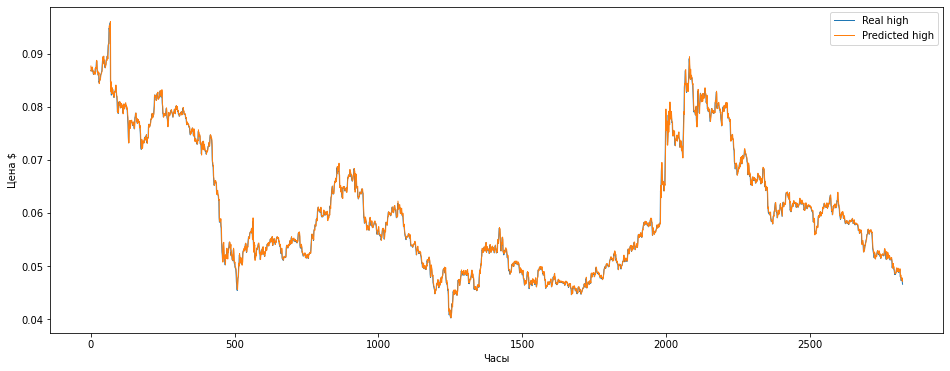

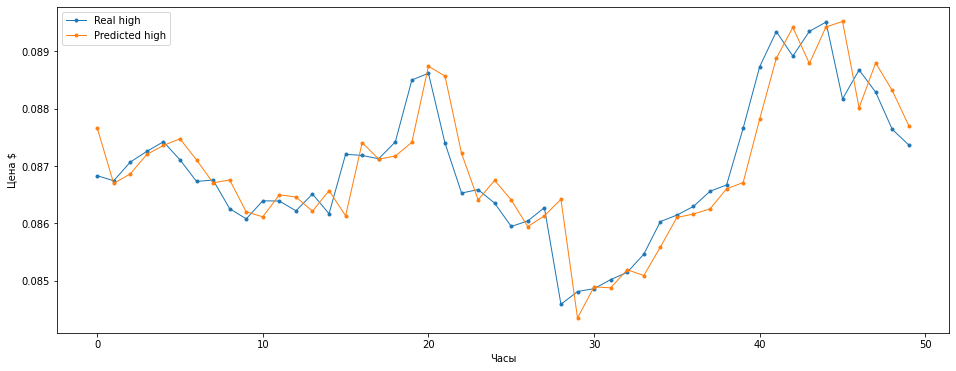

In [33]:
if diff_ch == 1:
    df=pd.DataFrame(inv_high_test)#, index = high_real[len(high_real)-len(inv_high_test):].index)
    df.rename(columns = {0:'Real high'},inplace =True)
    df['Predicted high']=inv_high_x
    #df['Close']=close['Close'][len(high_real)-len(inv_high_test):]
    df.plot(figsize=(16,6), linewidth = 1, ylabel = 'Цена $', xlabel = 'Часы')
    #df[int(df.shape[0]*0.99):].plot(figsize=(16,6), linewidth = 1)
    df[:50].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы')
else:
    df=pd.DataFrame(high_test.values) #high_real[len(high_real)-len(high_test):].index)
    
    df.rename(columns = {0:'Real high'},inplace =True)
    df['Predicted high']=regressor_high.predict(high_x_test)
    #df['Close']=close['Close'][len(high_real)-len(high_test):]
    df.plot(figsize=(16,6), linewidth = 1, ylabel = 'Цена $', xlabel = 'Часы' )
    #df[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)
    df[:50].plot(figsize=(16,6), linewidth = 1, style='.-', ylabel = 'Цена $', xlabel = 'Часы')

In [34]:
high_test.values

array([0.08683258, 0.08674375, 0.08706974, ..., 0.04760349, 0.04712017,
       0.04656235])

In [35]:
'''
df=pd.DataFrame(inv_low_test, index = low_real[len(low_real)-len(inv_low_test):].index)
df.rename(columns = {0:'Inv Real low'},inplace =True)
df['Real low']=low_real[len(low_real)-len(inv_low_test):]
#df['Close']=close['Close'][len(low_real)-len(inv_low_test):]
df.plot(figsize=(16,6))
df[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)
'''

"\ndf=pd.DataFrame(inv_low_test, index = low_real[len(low_real)-len(inv_low_test):].index)\ndf.rename(columns = {0:'Inv Real low'},inplace =True)\ndf['Real low']=low_real[len(low_real)-len(inv_low_test):]\n#df['Close']=close['Close'][len(low_real)-len(inv_low_test):]\ndf.plot(figsize=(16,6))\ndf[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)\n"

# Графики - Low

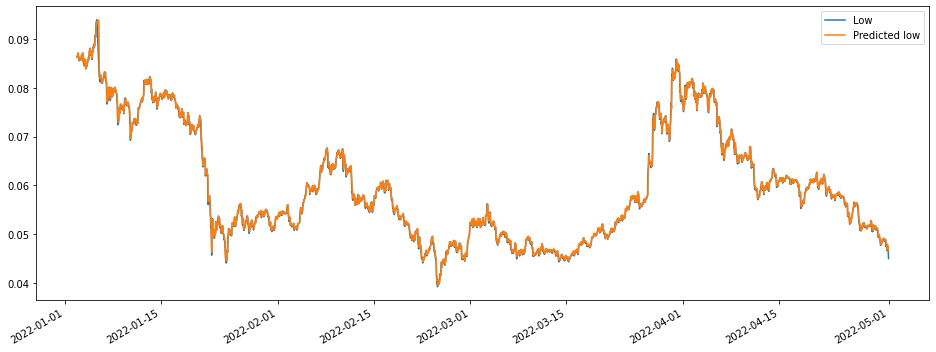

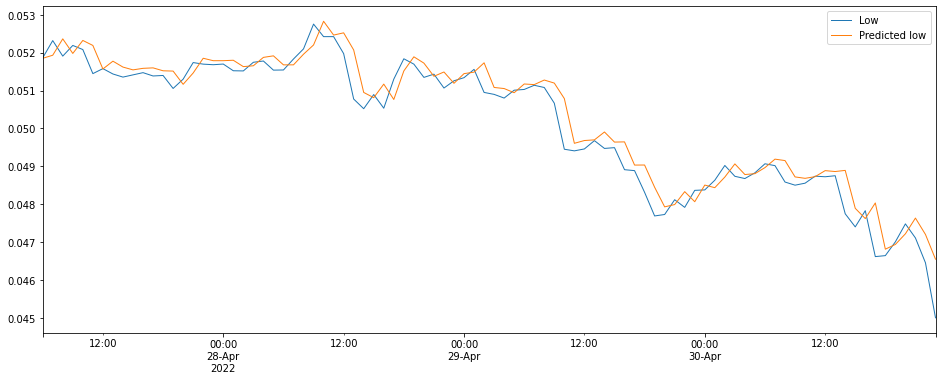

In [36]:
if diff_ch == 1:
    df=pd.DataFrame(inv_low_test, index = low_real[len(low_real)-len(inv_low_test):].index)
    df.rename(columns = {0:'Real low'},inplace =True)
    df['Predicted low']=inv_low_x
    #df['Close']=close['Close'][len(low_real)-len(inv_low_test):]
    df.plot(figsize=(16,6))
    #df[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)
    df[-90:].plot(figsize=(16,6), linewidth = 1)
else:
    df=pd.DataFrame(low_test, index = low_real[len(low_real)-len(low_test):].index)
    df.rename(columns = {0:'Real low'},inplace =True)
    df['Predicted low']=regressor_low.predict(low_x_test)
    #df['Close']=close['Close'][len(low_real)-len(inv_low_test):]
    df.plot(figsize=(16,6))
    #df[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)
    df[-90:].plot(figsize=(16,6), linewidth = 1)

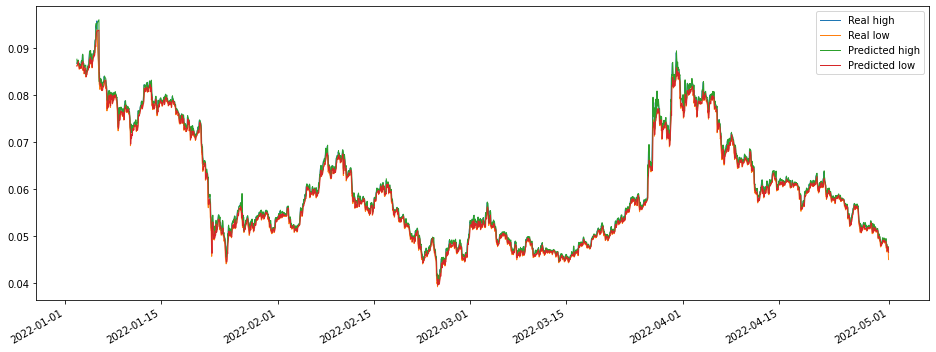

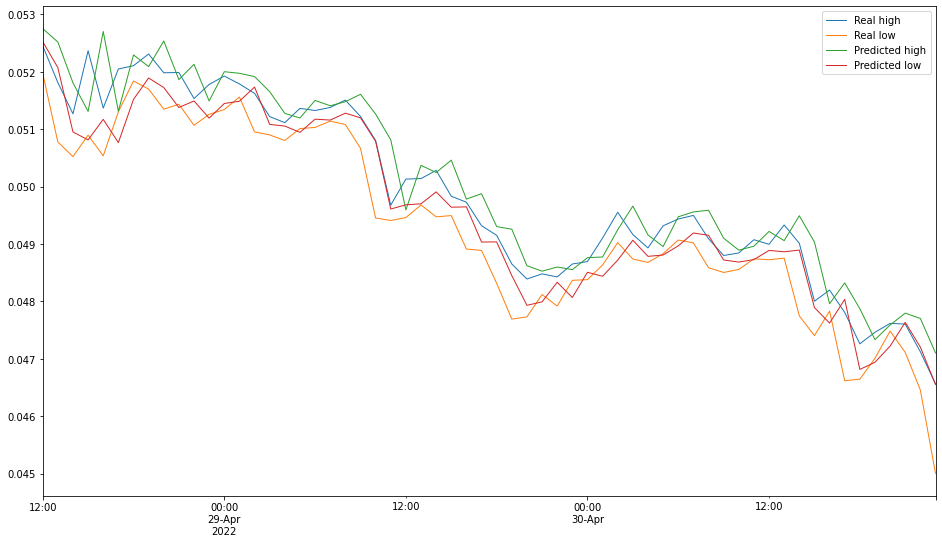

In [37]:
if diff_ch == 1:
    df=pd.DataFrame({'Real high':inv_high_test.reshape(1,-1)[0],'Real low':inv_low_test.reshape(1,-1)[0]}, index = high_real[len(high_real)-len(inv_high_test):].index)
    #df.rename(columns = {0:'Real high'},inplace =True)
    df['Predicted high']=inv_high_x
    df['Predicted low']=inv_low_x
    #df['Close']=close['Close'][len(high_real)-len(inv_high_test):]
    df.plot(figsize=(16,6), linewidth = 1 )
    #df[int(df.shape[0]*0.99):].plot(figsize=(16,6), linewidth = 1)
    df[-60:].plot(figsize=(16,9), linewidth = 1)
else:
    df=pd.DataFrame(high_test, index = high_real[len(high_real)-len(high_test):].index)
    df=pd.DataFrame({'Real high':high_test,'Real low':low_test}, index = high_real[len(high_real)-len(high_test):].index)
    #df.rename(columns = {0:'Real high'},inplace =True)
    df['Predicted high']=regressor_high.predict(high_x_test)
    df['Predicted low']=regressor_low.predict(low_x_test)
    #df['Close']=close['Close'][len(high_real)-len(high_test):]
    df.plot(figsize=(16,6), linewidth = 1 )
    #df[int(df.shape[0]*0.95):].plot(figsize=(8,8), linewidth = 1)
    df[-60:].plot(figsize=(16,9), linewidth = 1)

# Торговля

In [38]:
def traiding(high_train, low_train, high_test, low_test, close, l, depozit):
    
    colvo=0
    all_profit = 0
    profit = 0
    pos = False
    num_steps = len(close)
    deals = []
    comission = 0.1 # %
    koef = (1-comission/100)
    for step in range(num_steps):
        buy_price = low_train[step][0]*l
        sell_price = high_train[step][0]*l
        if buy_price >= low_test[step][0]:
            pos = True
            sdelka = depozit//2
            depozit -= sdelka
            colvo = sdelka * koef / buy_price
            profit -= sdelka * comission /100  
        if pos:
            if sell_price <= high_test[step][0]:
                p = colvo * (koef * sell_price - buy_price)
                sdelka = colvo * koef * sell_price
                status = 'success'
            else:
                sell_price = close[step]
                p = colvo * (koef * sell_price - buy_price)
                sdelka = colvo * koef * sell_price
                if p<=0:
                    status = 'failed'
                else:
                    status = 'bought at closing price'
            profit += p
            depozit += sdelka
            pos = False
            deals.append({'status' : status, 
                          'buy_price' : buy_price, 
                          'sell_price' : sell_price, 
                          'profit' : p, 
                          'depozit' : depozit})
            if depozit <=0:
                print(f"depozit= {depozit}")
                return deals, profit
    return deals, profit

In [39]:
l = 1
depozit = 100

if diff_ch == 1:
    deals, profit = traiding(inv_high_x, inv_low_x, inv_high_test, inv_low_test, close['Close'][len(close['Close'])-len(inv_low_x):], l, depozit)
    print(f'profit = {profit}; {profit*100/depozit : .3f} %' ) #sum([i['profit'] for i in deals])
    
    suc = sum([1 for i in deals if i['status']=='success'])
    a = sum([1 for i in deals if i['status']=='failed']) 
    b = sum([1 for i in deals if i['status']=='bought at closing price'])
    
    print()
    print('Amount of trades =', len(deals))
    print()
    print('Correctly predicted trades =', suc)
    print()
    print('Wrongly predicted trades =', a+b)  
    print('Bought at closing price - Loss =', a)
    print('Bought at closing price - Profit =', b)
    print()
    print('Profitable trades =', suc+b)
    

    deals
else:
    deals, profit = traiding(regressor_high.predict(high_x_test).reshape(-1,1), regressor_low.predict(high_x_test).reshape(-1,1), high_test.values.reshape(-1,1), low_test.values.reshape(-1,1), close['Close'][len(close['Close'])-len(low_test):], l, depozit)
    print(f'profit = {profit}; {profit*100/depozit : .3f} %' ) #sum([i['profit'] for i in deals])
    
    suc = sum([1 for i in deals if i['status']=='success'])
    a = sum([1 for i in deals if i['status']=='failed']) 
    b = sum([1 for i in deals if i['status']=='bought at closing price'])
    
    print()
    print('Amount of trades =', len(deals))
    print()
    print('Correctly predicted trades =', suc)
    print()
    print('Wrongly predicted trades =', a+b)  
    print('Bought at closing price - Loss =', a)
    print('Bought at closing price - Profit =', b)
    print()
    print('Profitable trades =', suc+b)

    deals

profit = -98.01330300841279; -98.013 %

Amount of trades = 2808

Correctly predicted trades = 1107

Wrongly predicted trades = 1701
Bought at closing price - Loss = 1701
Bought at closing price - Profit = 0

Profitable trades = 1107


In [40]:
dfff = pd.DataFrame(deals)
dfff

,status,buy_price,sell_price,profit,depozit
0,failed,0.087740,0.086550,-0.726527,99.223473
1,success,0.086925,0.086697,-0.177459,98.997014
2,success,0.086917,0.086864,-0.078787,98.869227
3,success,0.087226,0.087203,-0.062258,98.757969
4,success,0.087386,0.087359,-0.063925,98.645044
...,...,...,...,...,...
2803,success,0.047508,0.047332,-0.000000,1.986697
2804,success,0.047711,0.047587,-0.000000,1.986697
2805,failed,0.047796,0.047109,-0.000000,1.986697
2806,failed,0.047763,0.046453,-0.000000,1.986697


In [41]:
'''
joblib.dump(regressor_high, 'regressor_high.pkl', compress=9)
joblib.dump(regressor_low, 'regressor_low.pkl', compress=9)
'''

"\njoblib.dump(regressor_high, 'regressor_high.pkl', compress=9)\njoblib.dump(regressor_low, 'regressor_low.pkl', compress=9)\n"

In [42]:
#model_clone = joblib.load('my_model.pkl')